Understanding what is Lorenz system? because I will be using this equation as to find the governing equation for lorenz system in the following code.

As per wikipedia:


The Lorenz model is a system of three ordinary differential equations now known as the Lorenz equations:

\begin{aligned}{\frac {\mathrm {d} x}{\mathrm {d} t}}&=\sigma (y-x),\\[6pt]{\frac {\mathrm {d} y}{\mathrm {d} t}}&=x(\rho -z)-y,\\[6pt]{\frac {\mathrm {d} z}{\mathrm {d} t}}&=xy-\beta z.\end{aligned}

Over the past several years, a series of papers regarding high-dimensional Lorenz models have yielded a generalized Lorenz model,[22] which can be simplified into the classical Lorenz model for three state variables.

In the following code I am going to explain the following paper into networked system

####Paper Link: https://www.pnas.org/doi/full/10.1073/pnas.1517384113

The paper talks about the motivation behind discovering governing equations from data, particularly in systems where models are elusive, but data is abundant.

SINDy - Sparse Identification of Nonlinear Dynamics (SINDy)

PySinDy - sparse regression package with several implementations for the SINDy method

In [53]:
!pip install pysindy # install package if required
!pip install networkx matplotlib

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps
from scipy.integrate import odeint

The scipy.integrate.odeint function is used to solve ordinary differential equations (ODEs).

In the following code I am first defining the user defined function called lorenz_system
I will then apply PySINDy to the lorenz_system method to discover governing equations. I will use the data odeint function generates.

The assumption here is that the system dynamics can be expressed sparsely in a chosen function basis.

In [124]:
# Lorenz system definition
# dx/dt = sigma * (y - x)
# dy/dt = x * (rho - z) - y
# dz/dt = x * y - beta * z

def lorenz_system(x, t, sigma=10, beta=8/3, rho=28):
    dxdt = sigma * (x[1] - x[0])
    dydt = x[0] * (rho - x[2]) - x[1]
    dzdt = x[0] * x[1] - beta * x[2]
    return [dxdt, dydt, dzdt]

The below code is creating the time vector and initial conditions for simulation of the Lorenz system using odeint. This will create the data necessary for discovering the equations.

In [125]:
t = np.linspace(0, 25, 1000) # this is the time vector
x0 = [-8, 7, 27]  # these are the initial conditions

Odient method integrates a system of first-order ODEs given by a user-defined function.

In [126]:
data = odeint(lorenz_system, x0, t) # this is the state vector of the lorenz system

This "data" represents the state vector x(t)

##From https://pysindy.readthedocs.io/en/latest/:

If we suspect that the system could be well-modeled by a dynamical system of the form

x'(t) = f(x(t)),

then we can use SINDy to learn f(x) from the data (x'(t) denotes the time derivative of x(t)).

In [127]:
model = ps.SINDy()



The model.fit(data, t=t) function identifies the terms in the governing equations based on the given data and the time vector, which follows the paper’s method of fitting the sparse dynamics model.

In [128]:
model.fit(data, t=t)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=STLSQ())


PySINDy automatically creates such a library of candidate functions for sparse regression.

As you see in the above code, PySinDy, by default uses polynomials as the feature library. This can be modified to include other function types like trigonometric functions etc. The degree of the polynomial can also be specified.

In [129]:
model.print()

(x0)' = -9.865 x0 + 9.865 x1
(x1)' = 26.851 x0 + -0.789 x1 + -0.967 x0 x2
(x2)' = -2.618 x2 + 0.982 x0 x1


In [199]:
# Predicting the future state using the fitted governing model.
# x_pred = model.simulate(x0, t)

In [198]:
# Once the governing equations are identified, they can be used to predict future states of the system.
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(t, data[:, 0], 'r', label='True x')
# ax.plot(t, x_pred[:, 0], 'k--', label='Predicted x')
# ax.set_xlabel('Time')
# ax.set_ylabel('State x')
# plt.title('True vs predicted')
# ax.legend()
# plt.show()

Representing the governing equation in network system

In [132]:
import networkx as nx

equations = model.coefficients()  # get coefficients from the governing equation
terms = model.get_feature_names()  # get terms in the equations

In [196]:
equations # for sparse regression

array([[ 0.        , -9.86493651,  9.86489461,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , 26.85092719, -0.78862955,  0.        ,  0.        ,
         0.        , -0.96720613,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , -2.61809892,  0.        ,
         0.98184394,  0.        ,  0.        ,  0.        ,  0.        ]])

In [134]:
terms

['1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2']

Creating a directed graph using networkx

Adding nodes x,y and z for the original variables

In [143]:
G = nx.DiGraph()
variables = ['x', 'y','z']
G.add_nodes_from(variables)

Adding the nodes for polynomial terms (e.g., x^2, xy, etc.)

In [144]:
for term in terms:
    if term not in variables:  # make sure variable names are not added twice
        G.add_node(term)

G.nodes()

NodeView(('x', 'y', 'z', '1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2'))

In [145]:
variables

['x', 'y', 'z']

In [149]:
G.degree()

DiDegreeView({'x': 0, 'y': 0, 'z': 0, '1': 0, 'x0': 0, 'x1': 0, 'x2': 0, 'x0^2': 0, 'x0 x1': 0, 'x0 x2': 0, 'x1^2': 0, 'x1 x2': 0, 'x2^2': 0})

In [150]:
G.edges()

OutEdgeView([])

Add edges with weights corresponding to coefficients in the equations

In [151]:
for i, eq in enumerate(equations):
    for j, coeff in enumerate(eq):
        if coeff != 0:  # Only add edges for non-zero coefficients
            # Add an edge from the term to the variable
            G.add_edge(terms[j], variables[i], weight=coeff)

variables -->'x', 'y' and 'z'

terms --> '1', 'x0', 'x1', 'x2', 'x0^2', 'x0 x1', 'x0 x2', 'x1^2', 'x1 x2', 'x2^2'

creating an edge from each term to each variable that have non-zero coefficient

In [152]:
G.edges()

OutEdgeView([('x0', 'x'), ('x0', 'y'), ('x1', 'x'), ('x1', 'y'), ('x2', 'z'), ('x0 x1', 'z'), ('x0 x2', 'y')])

I am selecting the curcular layout to provide an equal distance between all nodes to make it visually appealing and clear.

In [186]:
pos = nx.circular_layout(G)
plt.figure(figsize=(12, 10))

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [188]:
node_colors = []
node_sizes = []
for node in G.nodes():
    if node in variables:
        node_colors.append('lightblue')  # lightblue colour for original variables x, y and z
        node_sizes.append(1500)
    else:
        node_colors.append('lightgreen')  # lightgreen colour for polynomial terms
        node_sizes.append(800)

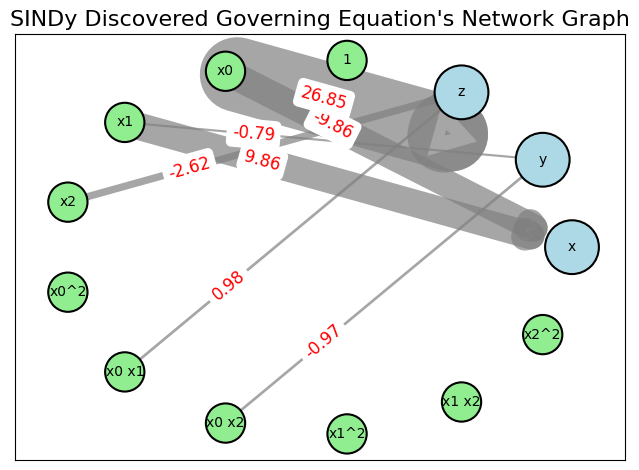

In [195]:
# drawing nodes with some customizations
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors="black", linewidths=1.5)

edges = G.edges(data=True) # drawing edges with thickness proportional to weight
edge_weights = [abs(d['weight']) * 2 for (u, v, d) in edges]  # scaling up edge thickness if the weight is more
nx.draw_networkx_edges(G, pos, edgelist=edges, width=edge_weights, edge_color="gray", alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_color="black") # drawing node labels here
edge_labels = {(u, v): f'{d["weight"]:.2f}' for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12, font_color="red", label_pos=0.3) # drawing edge labels (weights)

plt.title("SINDy Discovered Governing Equation's Network Graph", size=16)
plt.tight_layout()
plt.show()